<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Модель предсказания кол-ва заказов такси

Перед нами исторические данные о поездках такси, собранные правительством города Чикаго за 2022 и 2023 года. Данные предоставлены сайтом **Chicago Data Portal** ([2022 год](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz), [2023 год](https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb))

Цель работы: Разработать модель машинного обучения, способную предсказывать количество заказов на каждом округе на следующий час. Это может помочь правильно рассредотачивать водителей такси в зависимости от потребностей района, снизить среднее время ожидания машины клиентом и, как следствие, возможно благоприятно скажется на загруженности дорог города.

**Описание данных:**
- Trip ID - Уникальный идентификатор поездки.
- Taxi ID - Уникальный идентификатор такси.
- Trip Start Timestamp - Время начала поездки (округляется до ближайших 15 минут).
- Trip End Timestamp - Когда поездка закончилась (округляется до ближайших 15 минут).
- Trip Seconds - Время поездки в секундах.
- Trip Miles - Расстояние поездки в милях.
- Pickup Census Tract - Переписной тракт, где началась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок (этот столбец часто будет пустым для мест за пределами Чикаго).
- Dropoff Census Tract - Переписной тракт, где закончилась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок (этот столбец часто будет пустым для мест за пределами Чикаго).
- Pickup Community Area - Общественная зона, где началось путешествие (этот столбец будет пустым для местоположений за пределами Чикаго). 
- Dropoff Community Area - Общественная зона, где закончилась поездка (этот столбец будет пустым для местоположений за пределами Чикаго).
- Fare - Стоимость поездки.
- Tips - Чаевые (денежные чаевые обычно не учитываются).
- Tolls - Стоимость проезда.
- Extras - Дополнительные расходы на поездку.
- Trip Total - Общая стоимость поездки (сумма предыдущих столбцов).
- Payment Type - Вид оплаты.
- Company - Компания-перевозчик.
- Pickup Centroid Latitude - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Pickup Centroid Longitude - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Pickup Centroid Location - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid Latitude - Широта центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid Longitude - Долгота центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.
- Dropoff Centroid  Location - Местоположение центра переписного участка или общественной территории, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто будет пустым для мест за пределами Чикаго.

## Изучение общей информации о данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# RandomState
state = 16082023

In [2]:
# Создаём сессию
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting").master(f"spark://{SPARK_MASTER_IP}:7077").config("spark.executor.cores", 1).config("spark.task.cpus", 1).config("spark.driver.memory", "10g").getOrCreate()

In [3]:
# Загружаем данные
df_2022 = spark.read.csv("datasets/Taxi_Trips_-_2022.csv", header = True, inferSchema = True)
df_2023 = spark.read.csv("datasets/Taxi_Trips_-_2023.csv", header = True, inferSchema = True)

In [4]:
# Выводим кол-во строк в датафрейме, примеры строк, схему и описательные статистики
for df, name in zip([df_2022, df_2023], ['Taxi_Trips_-_2022', 'Taxi_Trips_-_2023']):
    df = df.fillna(0)
    print('Краткий обзор датафрейма', '\033[1m' + name + '\033[0m')
    print(f'Количество строк в датафрейме: {df.count()}')
    print('Колонки и их типы данных:')
    print(df.printSchema())
    print('Первые 5 строк датафрейма:')
    print(df.select(df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9], df[10]).show(5))
    print(df.select(df[11], df[12], df[13], df[14], df[15], df[16], df[17], df[18], df[20], df[21], df[22]).show(5))
    print('Описательные статистики датафрейма:')
    print(df.select(df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9]).summary().show())
    print(df.select(df[10], df[11], df[12], df[13], df[14]).summary().show())
    print()
    print('---------------------------------------------------------------------------------------------------------------')
    print()

Краткий обзор датафрейма Taxi_Trips_-_2022
Количество строк в датафрейме: 6382425
Колонки и их типы данных:
root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = false)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = false)
 |-- Tips: double (nullable = false)
 |-- Tolls: double (nullable = false)
 |-- Extras: double (nullable = false)
 |-- Trip Total: double (nullable = false)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = false)
 |-- Pickup Centroid Longitude: double (nullable = false)
 |-- Pickup Centroi

## EDA

Объединим данные за 2022 и 2023 года в один датафрейм

In [5]:
df = df_2022.union(df_2023)

Поменяем тип данных колонок 'Trip Start Timestamp' и 'Trip End Timestamp' на timestamp

In [6]:
for col in ['Trip Start Timestamp', 'Trip End Timestamp']:
    df = df.withColumn(
        col,
        to_timestamp(
            unix_timestamp(
                col,
                'MM/dd/yyyy hh:mm:ss a'
            )
        )
    )
    
    
    df_2022 = df_2022.withColumn(
        col,
        to_timestamp(
            unix_timestamp(
                col,
                'MM/dd/yyyy hh:mm:ss a'
            )
        )
    )
    

Для исследовательского анализа данных будем использовать рандомизированную выборку  (5% от всех данных) за 2022 год. Это позволит нам получить примерное представление о сезонности и трендах

In [39]:
eda_df = df_2022.sample(False, 0.05, seed=state).toPandas();

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


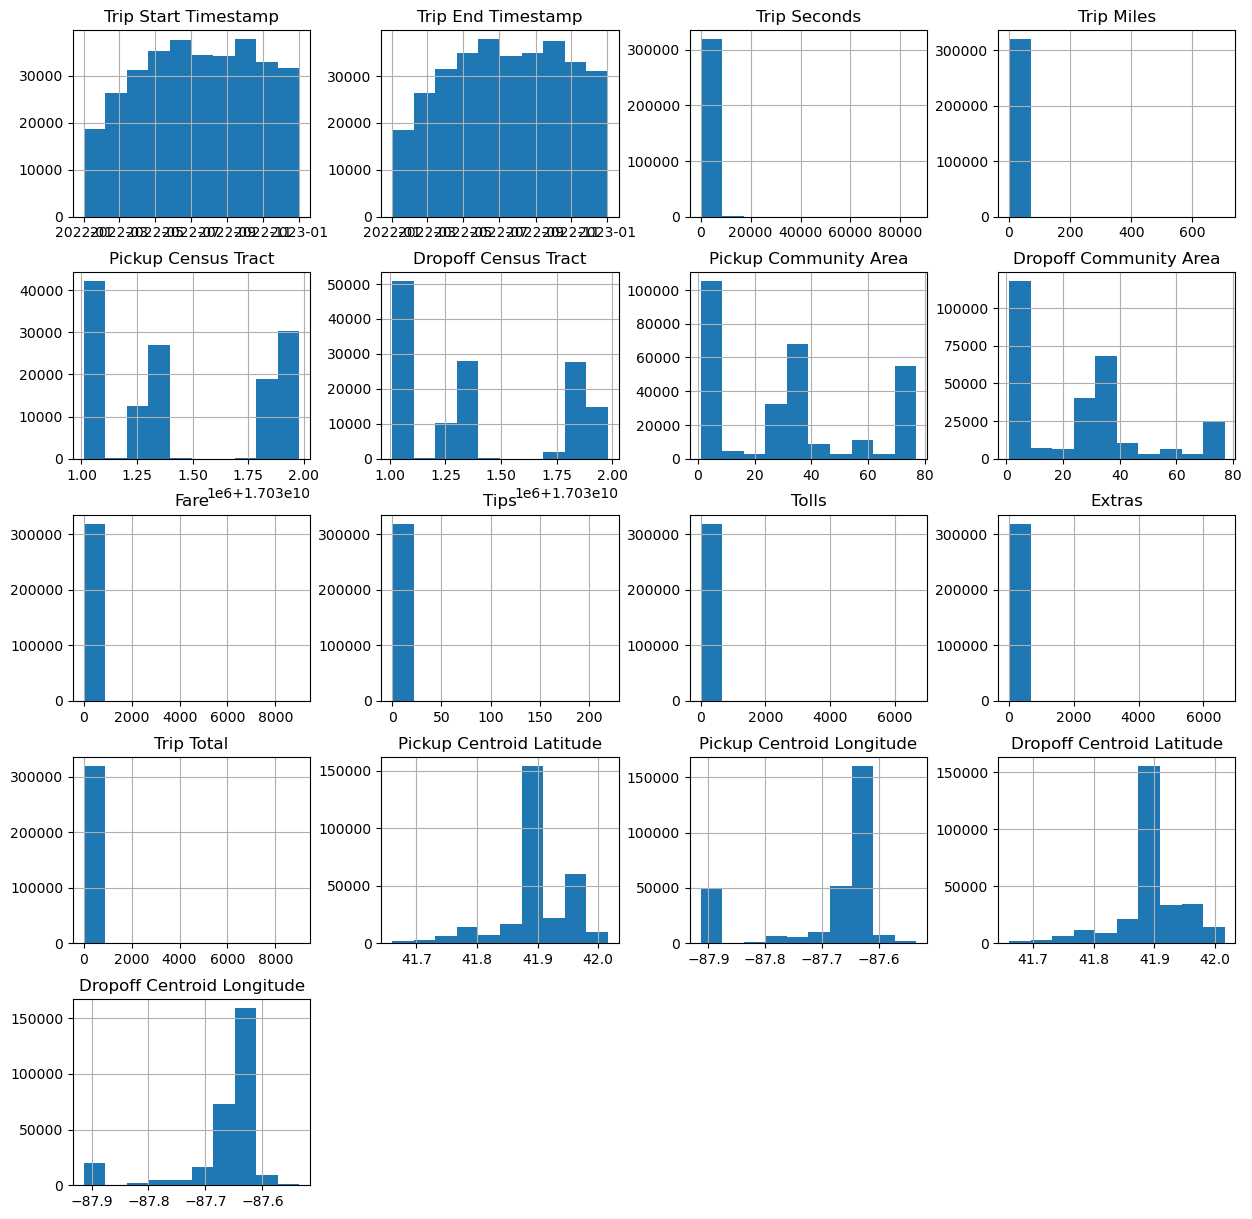

In [8]:
eda_df.hist(figsize=(15,15));

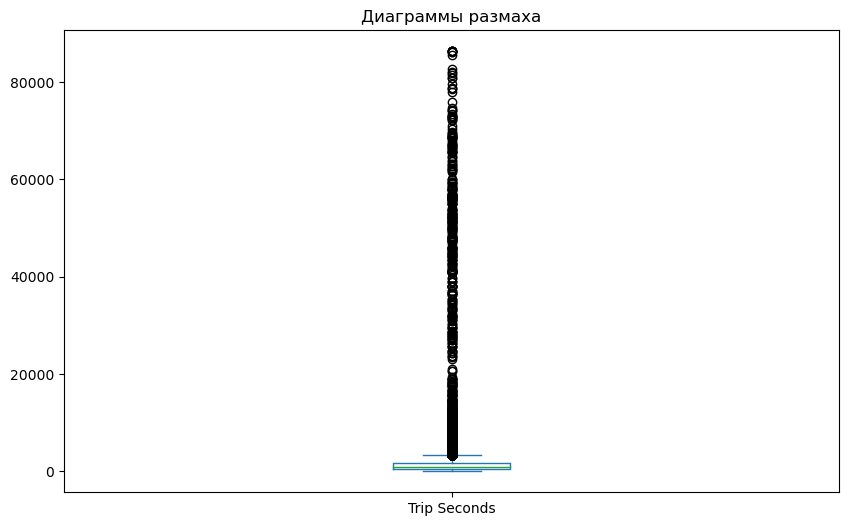

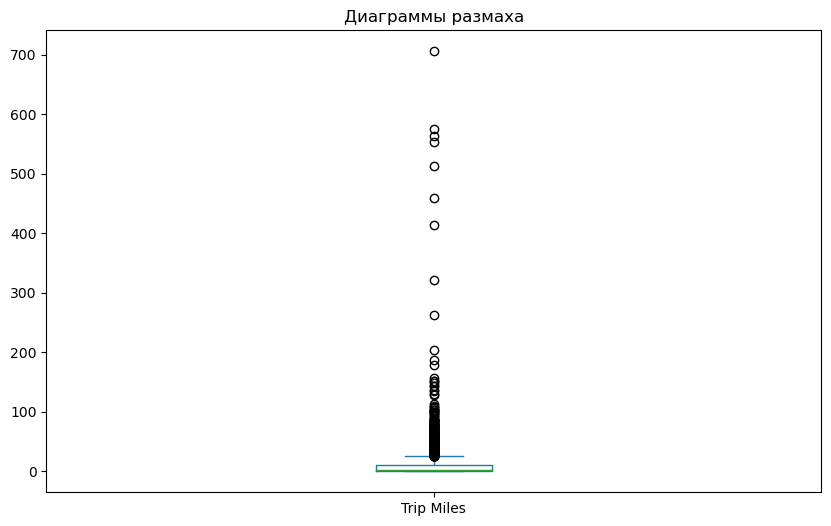

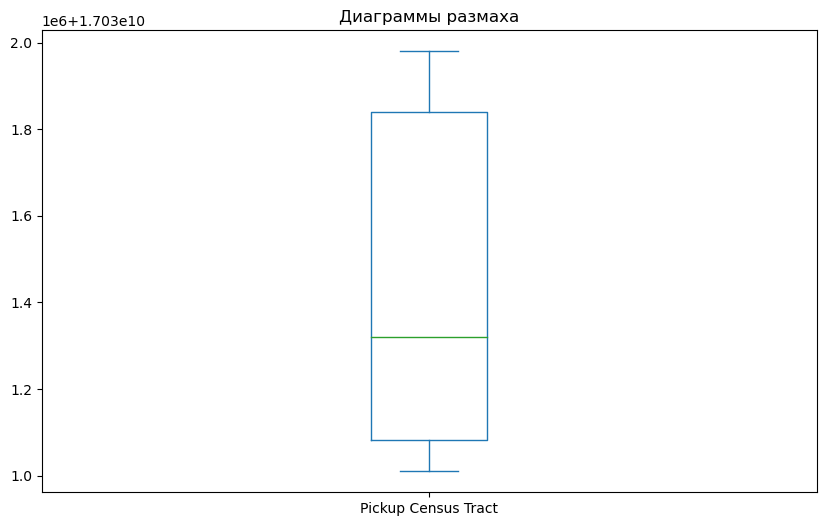

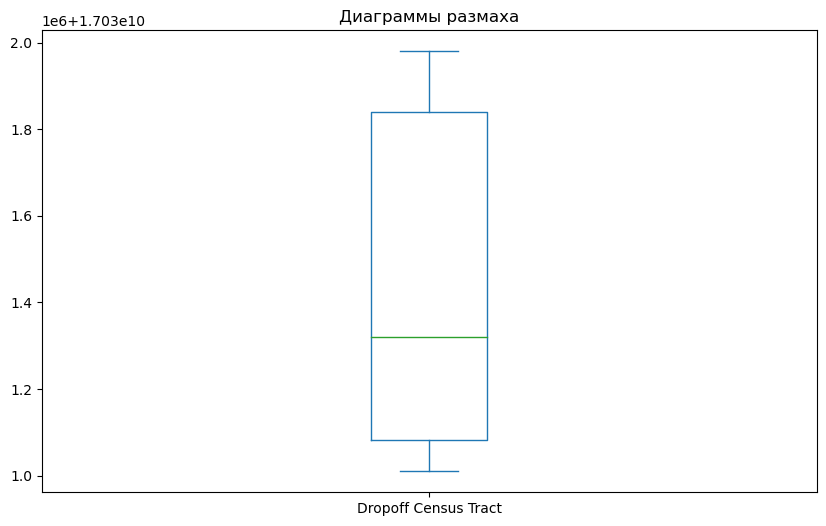

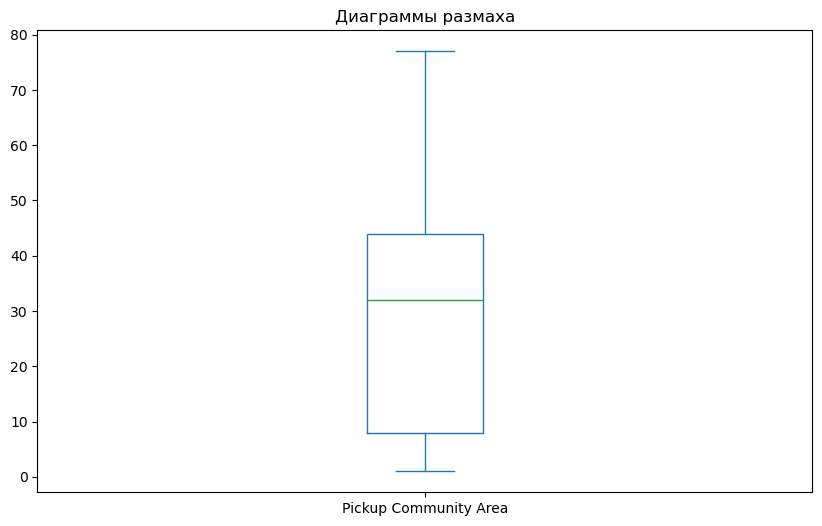

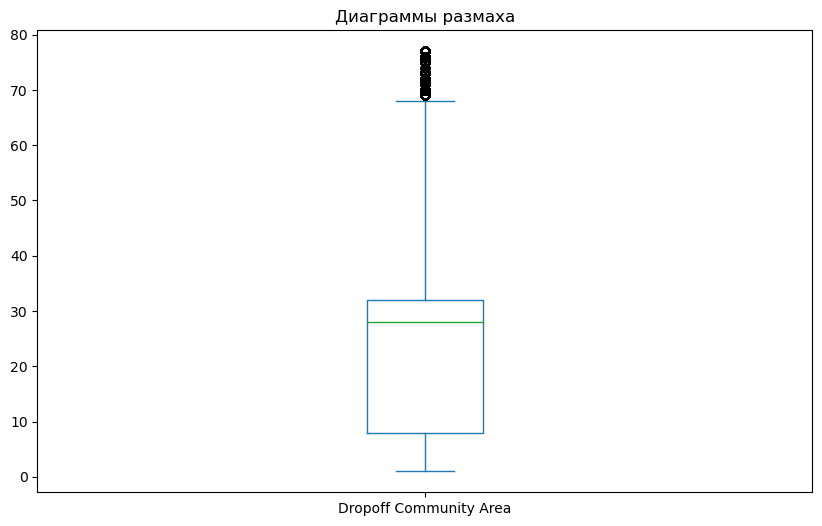

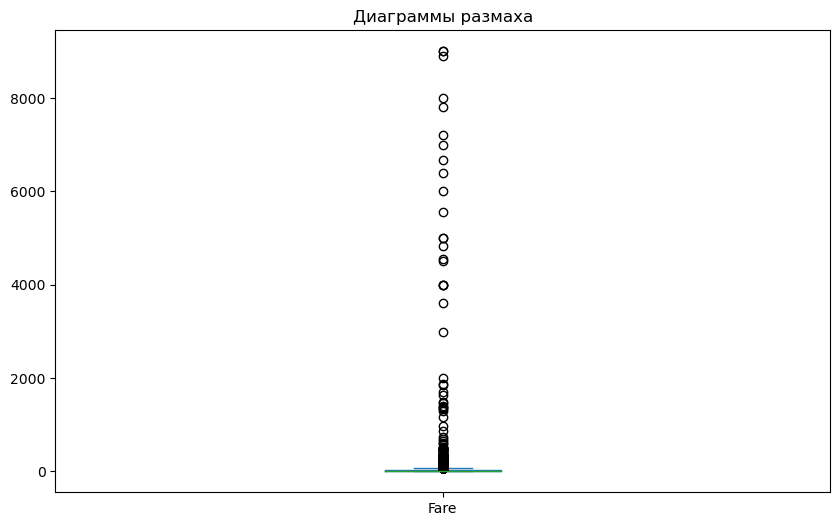

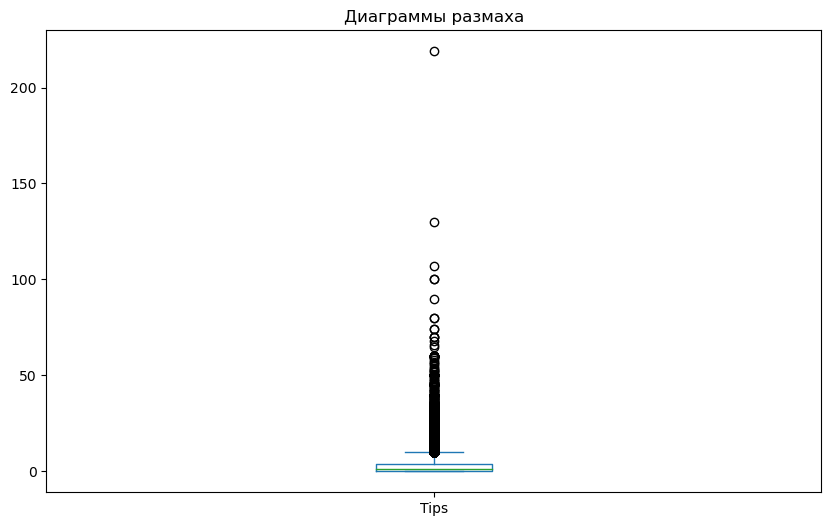

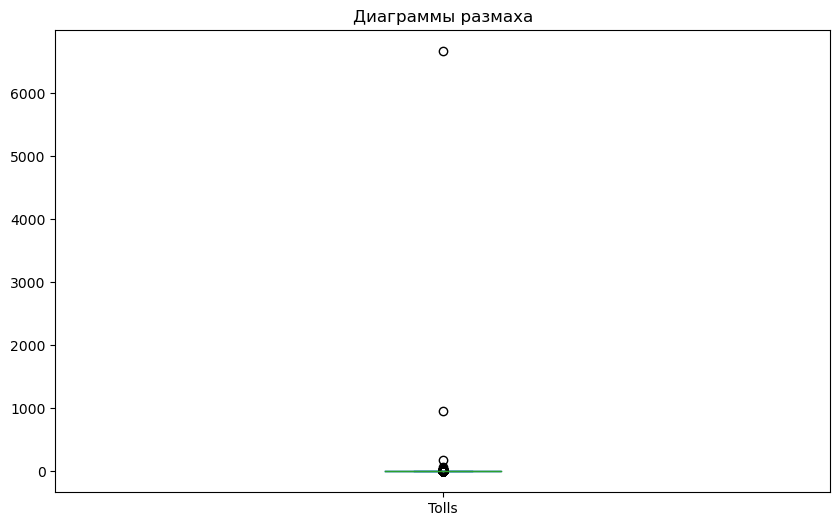

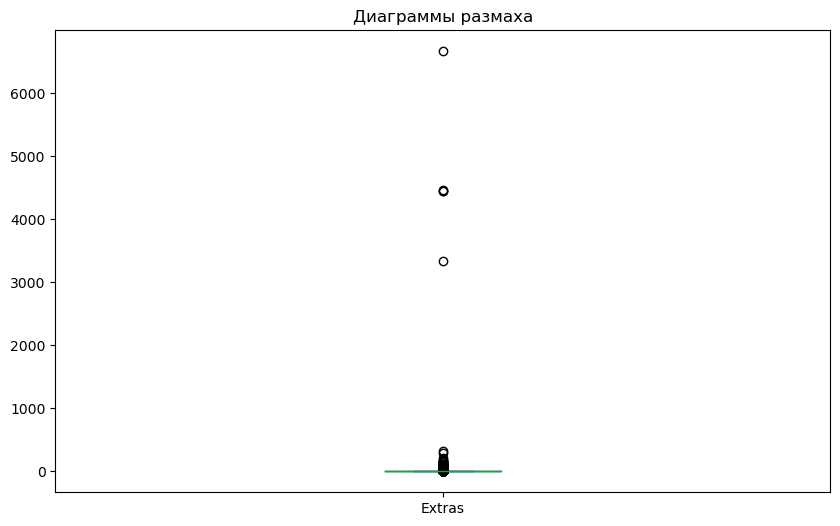

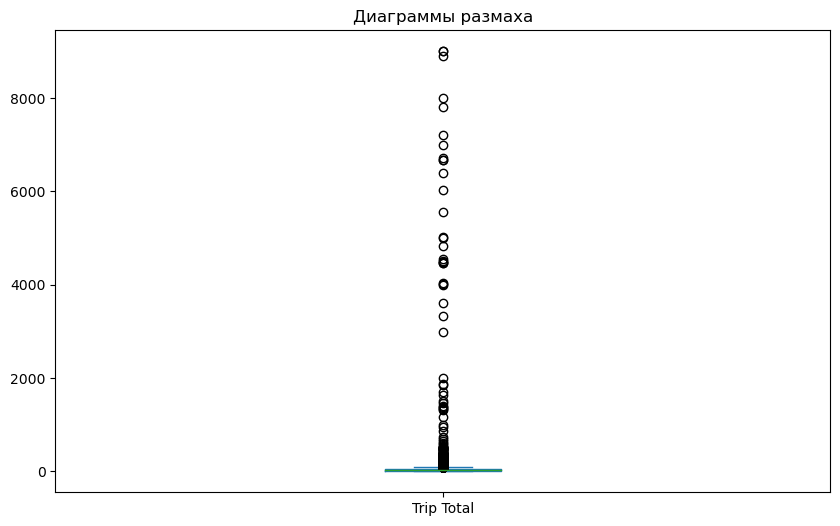

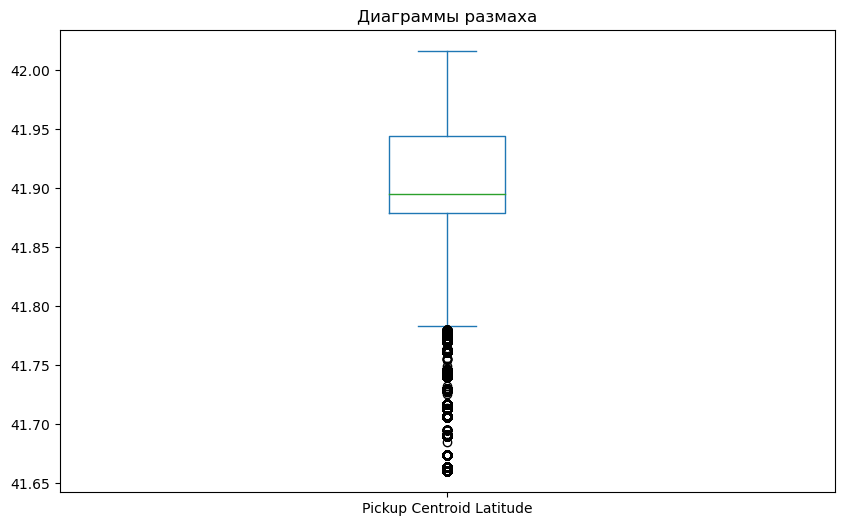

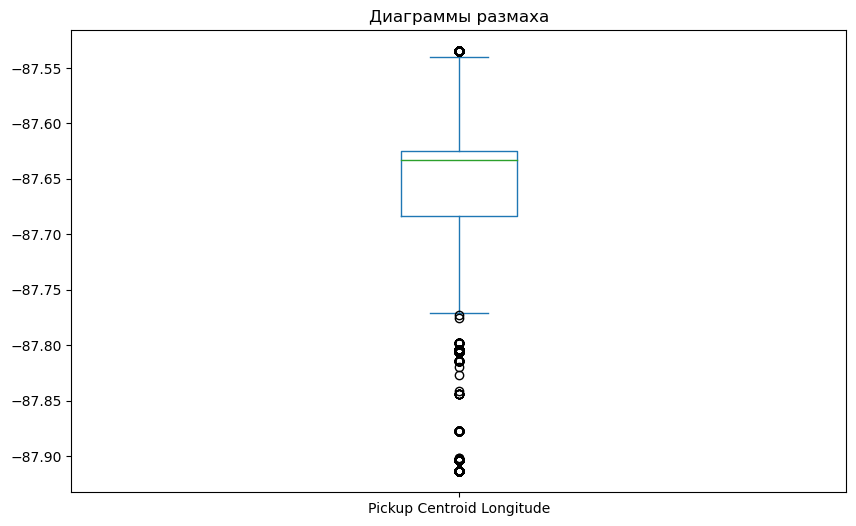

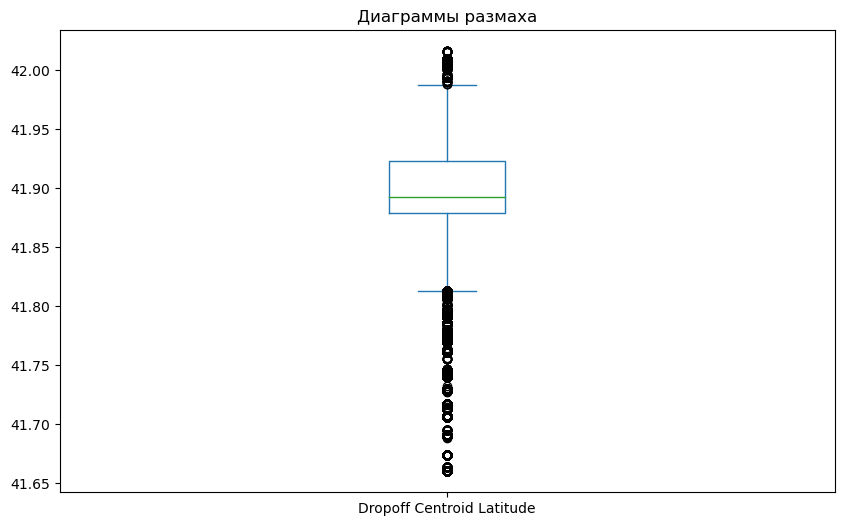

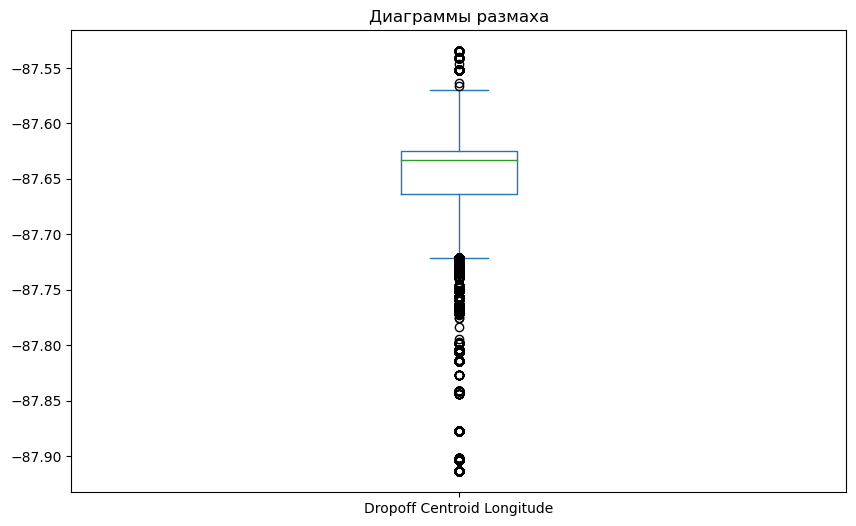

In [9]:
for col in eda_df.columns:
    try:
        eda_df[col].plot(kind='box', figsize=(10,6))
        plt.title("Диаграммы размаха")
        plt.show();
    except: continue

В данных присутствует множество выбросов

In [10]:
eda_df.corr(numeric_only=True).style.background_gradient(cmap ='seismic')\
.set_properties(**{'font-size': '12px'})

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
Trip Seconds,1.000000,0.363235,0.262804,0.101964,0.193927,0.098639,0.145078,0.181034,0.000269,0.031098,0.152844,0.084117,-0.212956,0.033161,-0.123360
Trip Miles,0.363235,1.000000,0.417841,0.170156,0.434974,0.214292,0.269941,0.430416,0.001293,0.096428,0.304237,0.167717,-0.462083,0.023288,-0.230449
Pickup Census Tract,0.262804,0.417841,1.000000,0.043958,0.879439,0.034061,0.175963,0.367727,0.004739,0.114098,0.214387,0.381626,-0.753239,0.058378,-0.067787
Dropoff Census Tract,0.101964,0.170156,0.043958,1.000000,0.043743,0.805303,0.074010,0.125248,0.005186,0.014698,0.079651,0.010143,-0.024992,0.193943,-0.613783
Pickup Community Area,0.193927,0.434974,0.879439,0.043743,1.000000,0.113559,0.160525,0.357925,0.004212,0.101822,0.202491,0.144742,-0.767555,-0.072264,-0.046659
Dropoff Community Area,0.098639,0.214292,0.034061,0.805303,0.113559,1.000000,0.103744,0.078401,0.005184,0.007699,0.098480,-0.179163,0.038892,-0.203003,-0.539896
Fare,0.145078,0.269941,0.175963,0.074010,0.160525,0.103744,1.000000,0.153032,0.000498,0.032990,0.918015,0.059502,-0.167201,0.014914,-0.113906
Tips,0.181034,0.430416,0.367727,0.125248,0.357925,0.078401,0.153032,1.000000,-0.000587,0.103101,0.240793,0.247483,-0.440868,0.144344,-0.182910
Tolls,0.000269,0.001293,0.004739,0.005186,0.004212,0.005184,0.000498,-0.000587,1.000000,0.001846,0.198976,0.003136,-0.004996,0.003199,-0.007047
Extras,0.031098,0.096428,0.114098,0.014698,0.101822,0.007699,0.032990,0.103101,0.001846,1.000000,0.366777,0.053748,-0.117500,0.008845,-0.016575


Корреляции выглядят вполне логично. Интересным наблюдением кажутся явная взаимосвязь между чаевыми и районом начала поездки и широтой и взаимосвязь между районом начала поездки и расстоянием

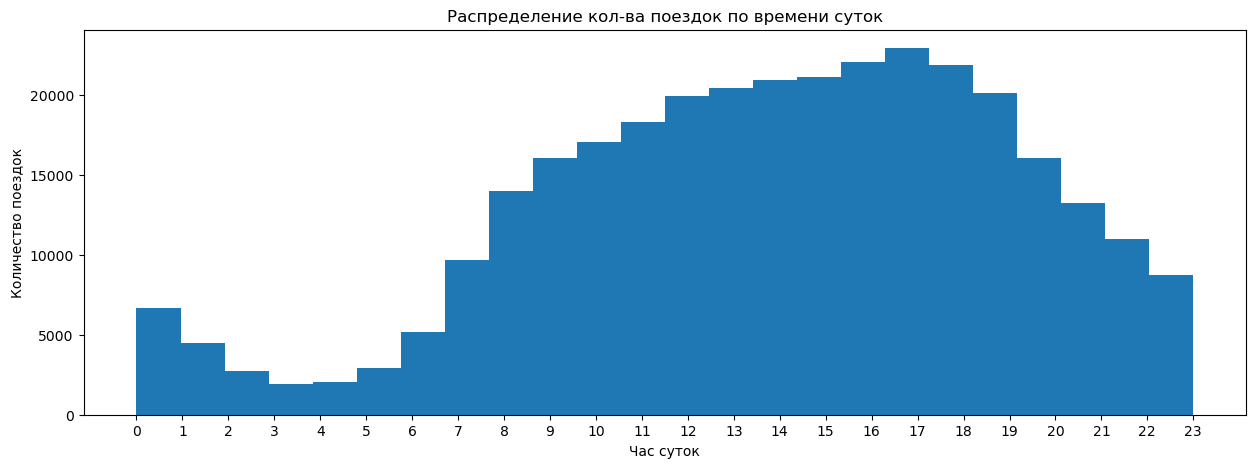

In [41]:
eda_df['Hour'] = eda_df['Trip Start Timestamp'].dt.hour
plt.figure(figsize=(15,5))
plt.hist(eda_df['Hour'], bins=24)
plt.xticks(range(0,24))
plt.title('Распределение кол-ва поездок по времени суток')
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.show()

На графике видно, что час пик приходится на промежуток между 15:00 и 18:00, а в ночные часы совершается куда меньше поездок, чем днём

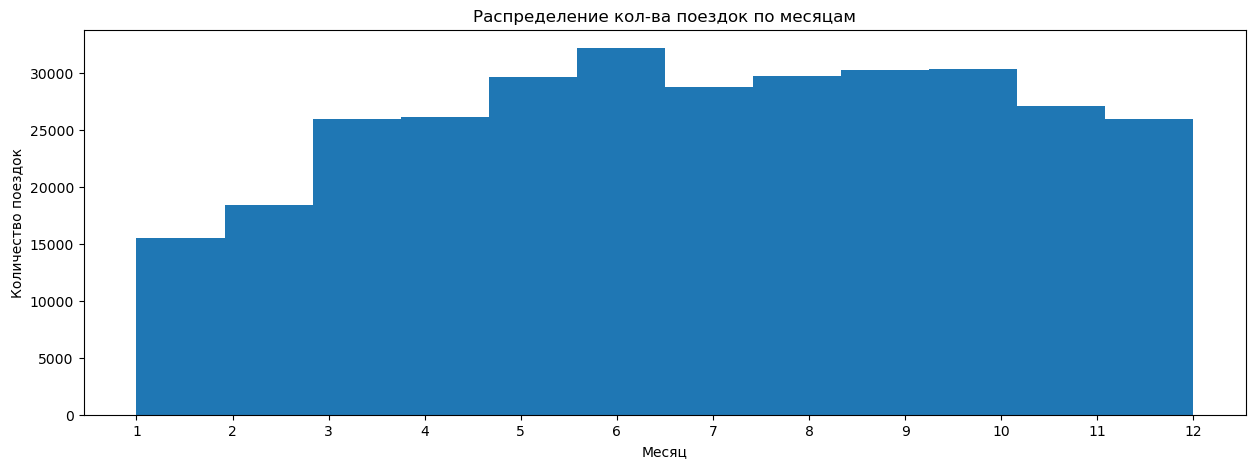

In [12]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Start Timestamp'].dt.month, bins=12)
plt.xticks(range(1,13))
plt.title('Распределение кол-ва поездок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество поездок')
plt.show()

На графике заметна некоторая сезонность - летом можно увидеть пик, а к зиме наблюдается небольшой спад

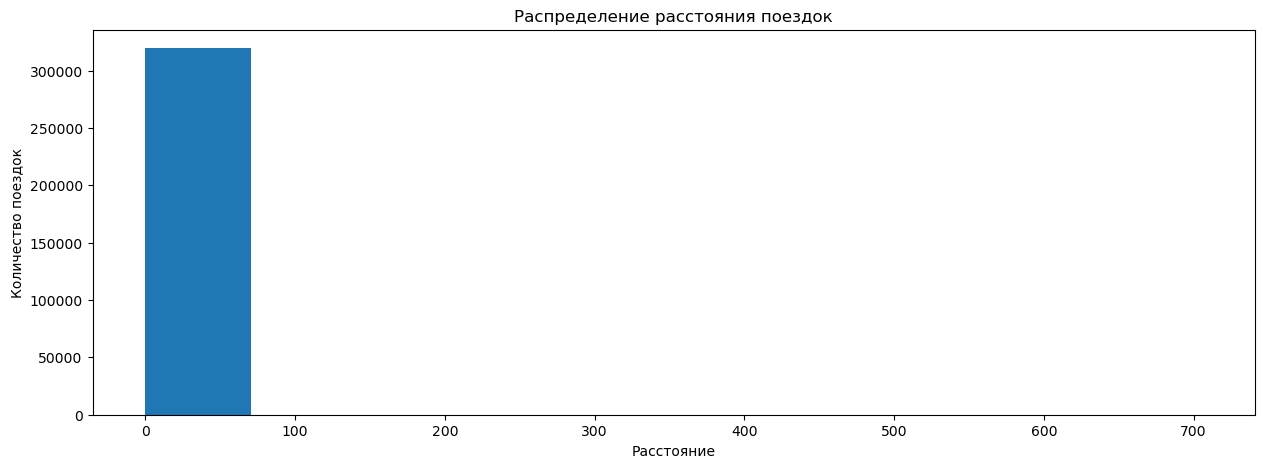

In [13]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Miles'])
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

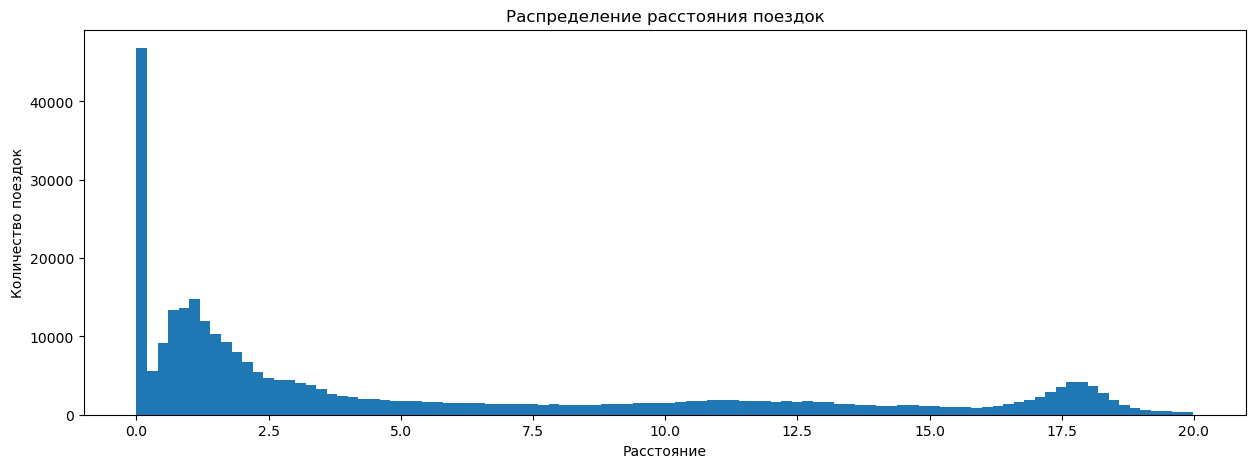

In [14]:
plt.figure(figsize=(15,5))
plt.hist(eda_df['Trip Miles'].loc[eda_df['Trip Miles'] < 20], bins=100)
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Для большинства поездок расстояние не зафиксировано

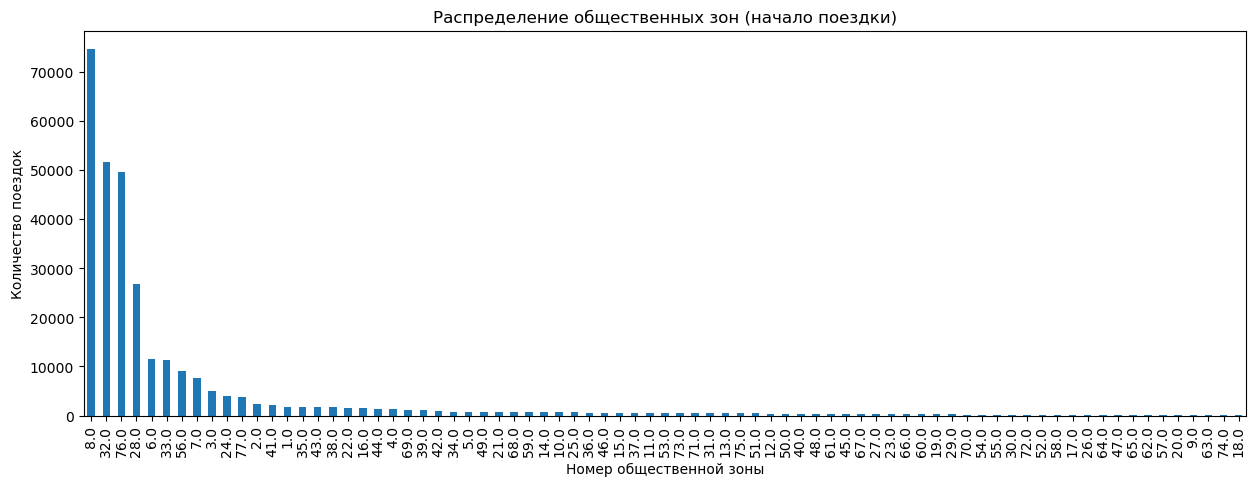

In [15]:
plt.figure(figsize=(15,5))
eda_df['Pickup Community Area'].value_counts().plot(kind='bar')
plt.title('Распределение общественных зон (начало поездки)')
plt.xlabel('Номер общественной зоны')
plt.ylabel('Количество поездок')
plt.show()

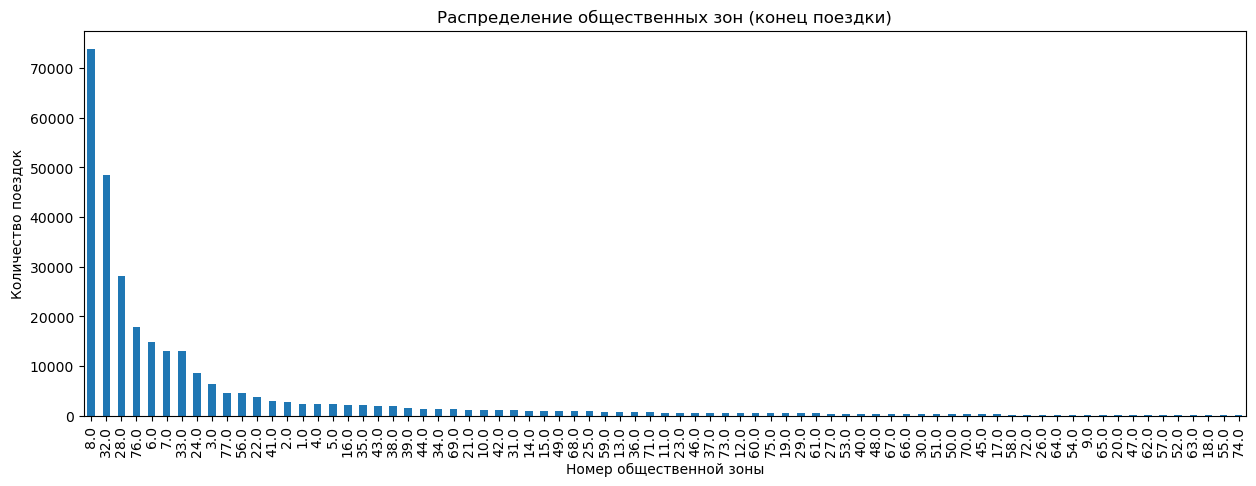

In [16]:
plt.figure(figsize=(15,5))
eda_df['Dropoff Community Area'].value_counts().plot(kind='bar')
plt.title('Распределение общественных зон (конец поездки)')
plt.xlabel('Номер общественной зоны')
plt.ylabel('Количество поездок')
plt.show()

8 общественная зона опредённо является самой популярной. Для многих округов данные предоставлены в крайне малом объёме, вряд ли модель сможет хорошо их объяснить.

In [42]:
temp_df = eda_df.drop(
    [
        'Trip End Timestamp', 
        'Pickup Census Tract','Dropoff Census Tract',
        'Dropoff Community Area', 'Payment Type', 
        'Company', 'Pickup Centroid Latitude',
        'Pickup Centroid Longitude', 'Pickup Centroid Location',
        'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
        'Dropoff Centroid  Location', 'Hour'
    ], axis=1
)

trip_count = temp_df.groupby(temp_df['Trip Start Timestamp'].dt.ceil("H"))['Trip ID'].nunique()

temp_df = temp_df.groupby(
    [temp_df['Trip Start Timestamp'].dt.ceil("H")]
)[
    [
        'Trip Seconds', 'Trip Miles', 'Fare', 
        'Tips', 'Tolls', 'Extras', 'Trip Total'
    ]
].sum()

temp_df.index = pd.to_datetime(temp_df.index)
temp_df['trip_count'] = trip_count

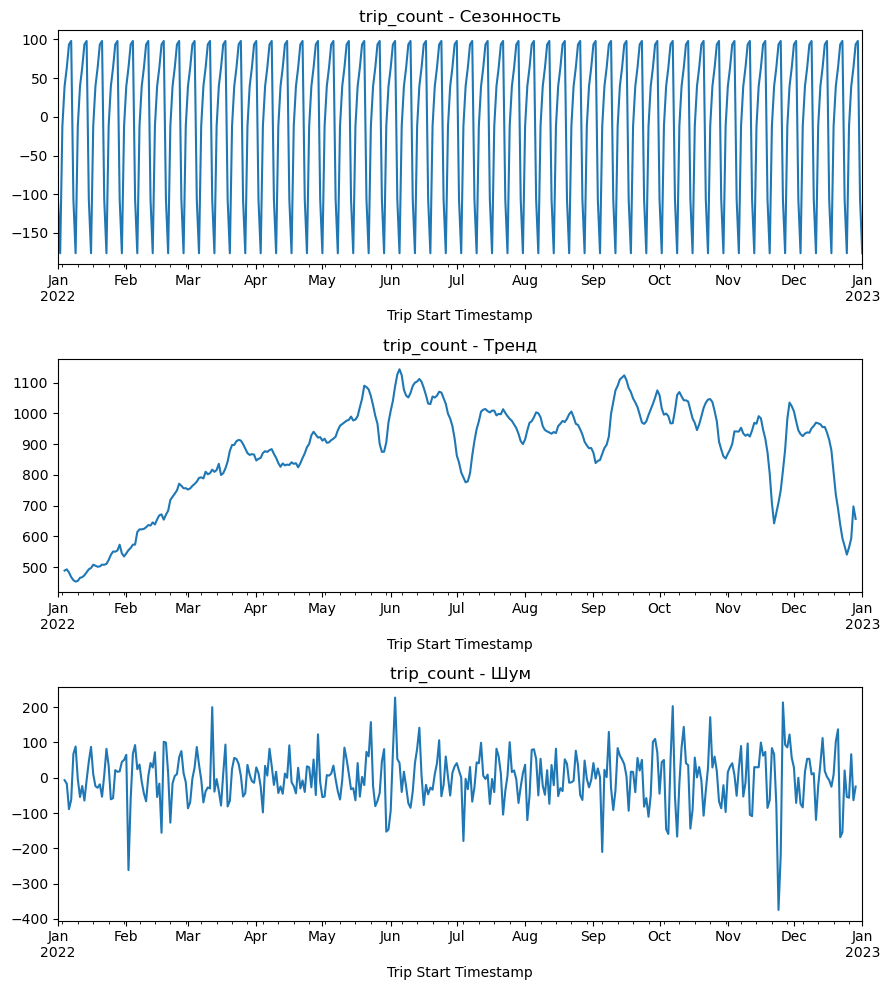

In [47]:
trip_count_1year = temp_df[['trip_count']]
trip_count_1year = trip_count_1year.resample('1D').sum()
decomposed = seasonal_decompose(trip_count_1year['trip_count'])

plt.figure(figsize=(9, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title(f'trip_count - Сезонность')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title(f'trip_count - Тренд')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title(f'trip_count - Шум')
plt.tight_layout()
plt.show();

В данных много шума, хорошо прослеживается недельная сезонность.

Выведем графики с плавающими средним и стандартным отклонением (данные ресемплированы по интервалам в 1 день, сглаживание по 10 дням)

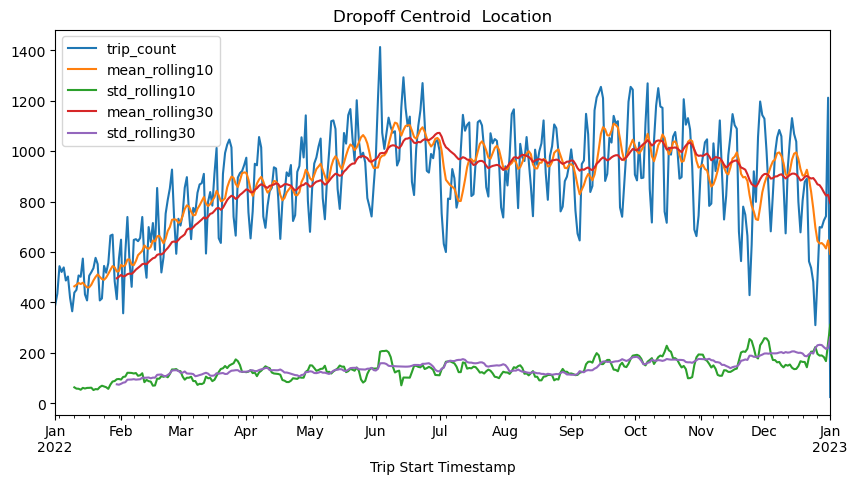

In [48]:
trip_count_1year['mean_rolling10'] = trip_count_1year['trip_count'].rolling(10).mean()
trip_count_1year['std_rolling10'] = trip_count_1year['trip_count'].rolling(10).std()
trip_count_1year['mean_rolling30'] = trip_count_1year['trip_count'].rolling(30).mean()
trip_count_1year['std_rolling30'] = trip_count_1year['trip_count'].rolling(30).std()
trip_count_1year.plot(figsize=(10,5))
plt.title(f'{col}')
plt.show();

## Подготовка к обучению

Подготовим датафрейм к работе

In [20]:
for col in df.columns:
    df = df.withColumnRenamed(
        col, 
        col.lower().replace(' ', '_')
    )
df = df.na.drop(subset=["pickup_community_area"])

df.createOrReplaceTempView("data")

Сформируем датафрейм сгруппированный по интервалам в час и по округам со следующими признаками:
- 1) Время
- 2) Округ
- 3) Кол-во уникальных машин в округе
- 4) Кол-во заказов за текущий час
- 5) Лаг от кол-ва заказов с шагами от 1 до 24 часов
- 6) Лид от кол-ва заказов с шагом в 1 час <strong>(целевой признак)</strong>

In [21]:
df = spark.sql(
    "WITH table AS \
    (SELECT DATE_TRUNC('hour', trip_start_timestamp) as timestamp, \
    pickup_community_area as area, \
    COUNT(trip_id) AS current_orders, \
    COUNT(DISTINCT(taxi_id)) AS unique_taxi \
    FROM data \
    GROUP BY DATE_TRUNC('hour', trip_start_timestamp), pickup_community_area \
    ORDER BY DATE_TRUNC('hour', trip_start_timestamp), pickup_community_area) \
    SELECT timestamp, \
    area, \
    unique_taxi, \
    current_orders, \
    LAG(current_orders, 1) OVER (ORDER BY timestamp, area) AS lag1, \
    LAG(current_orders, 2) OVER (ORDER BY timestamp, area) AS lag2, \
    LAG(current_orders, 3) OVER (ORDER BY timestamp, area) AS lag3, \
    LAG(current_orders, 4) OVER (ORDER BY timestamp, area) AS lag4, \
    LAG(current_orders, 5) OVER (ORDER BY timestamp, area) AS lag5, \
    LAG(current_orders, 6) OVER (ORDER BY timestamp, area) AS lag6, \
    LAG(current_orders, 7) OVER (ORDER BY timestamp, area) AS lag7, \
    LAG(current_orders, 8) OVER (ORDER BY timestamp, area) AS lag8, \
    LAG(current_orders, 9) OVER (ORDER BY timestamp, area) AS lag9, \
    LAG(current_orders, 10) OVER (ORDER BY timestamp, area) AS lag10, \
    LAG(current_orders, 11) OVER (ORDER BY timestamp, area) AS lag11, \
    LAG(current_orders, 12) OVER (ORDER BY timestamp, area) AS lag12, \
    LAG(current_orders, 13) OVER (ORDER BY timestamp, area) AS lag13, \
    LAG(current_orders, 14) OVER (ORDER BY timestamp, area) AS lag14, \
    LAG(current_orders, 15) OVER (ORDER BY timestamp, area) AS lag15, \
    LAG(current_orders, 16) OVER (ORDER BY timestamp, area) AS lag16, \
    LAG(current_orders, 17) OVER (ORDER BY timestamp, area) AS lag17, \
    LAG(current_orders, 18) OVER (ORDER BY timestamp, area) AS lag18, \
    LAG(current_orders, 19) OVER (ORDER BY timestamp, area) AS lag19, \
    LAG(current_orders, 20) OVER (ORDER BY timestamp, area) AS lag20, \
    LAG(current_orders, 21) OVER (ORDER BY timestamp, area) AS lag21, \
    LAG(current_orders, 22) OVER (ORDER BY timestamp, area) AS lag22, \
    LAG(current_orders, 23) OVER (ORDER BY timestamp, area) AS lag23, \
    LAG(current_orders, 24) OVER (ORDER BY timestamp, area) AS lag24, \
    LEAD(current_orders, 1) OVER (ORDER BY timestamp, area) AS target \
    FROM table \
    ORDER BY timestamp"
)

Выделим из timestamp доступные нам данные о дате и времени.

In [22]:
df = df.withColumn('year',year(df.timestamp))
df = df.withColumn('month',month(df.timestamp))
df = df.withColumn('day_of_year',dayofyear(df.timestamp))
df = df.withColumn('day_of_month',dayofmonth(df.timestamp))
df = df.withColumn('day_of_week',dayofweek(df.timestamp))
df = df.withColumn('hour',hour(df.timestamp))

Удалим из полученного датафрейма строки с пропусками

In [23]:
df = df.na.drop()

Выделим колонки с признаками для последующей трансформации их в вектор признаков и стандартизации.

In [24]:
featureCols = [
    'year', 'month', 'day_of_year', 'day_of_month', 'day_of_week', 'hour',
    'area', 'unique_taxi', 'current_orders', 
    'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 
    'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
    'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 
    'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 
    'lag21', 'lag22', 'lag23', 'lag24'
]

Напишем кастомный пайплайн для обработки датасета.

In [25]:
def custom_pipeline(estimator):
    assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="features_scaled")
    estimator.setFeaturesCol(scaler.getOutputCol())
    pipeline = Pipeline(stages=[assembler, scaler, estimator])
    
    return pipeline

Разделим наши данные на три выборки: обучающую (80% данных) и тестовую (20%).

In [26]:
def train_test_split(df, train_size=0.8):
    train_len = int(df.count() * train_size)
    train = df.limit(train_len)
    test = df.subtract(train)
    
    return train, test

train, test = train_test_split(df)

## Обучение моделей

Для решения стоящей перед нами задачи регрессии протестируем следующие модели:
1) LinearRegression
2) DecisionTreeRegressor
3) RandomForestRegressor
5) GBTRegressor

In [27]:
# фич импортансы и суммари регрессии
def model_summary(estimator):

    pipeline = custom_pipeline(estimator)
    model = pipeline.fit(train)
    
    try:
        importances = model.stages[2].featureImportances.toArray()
        plt.figure(figsize=(15, 5))
        plt.title('Feature importances')
        plt.bar(featureCols, importances)
        plt.xticks(rotation=90)
        plt.show()
    except: pass
        
    try:
        print(f"RMSE модели: {model.summary.rootMeanSquaredError}, R2 модели: {model.summary.r2}")
    except: pass


# рассчёт rmse и r2
def evaluation_metrics(df, metrics=None):
    rmse = RegressionEvaluator(
        labelCol='target', 
        predictionCol='prediction', 
        metricName='rmse'
    ).evaluate(df)

    if metrics == 'Both':
        r2 = RegressionEvaluator(
            labelCol='target', 
            predictionCol='prediction', 
            metricName='r2'
        ).evaluate(df)
        
        return rmse, r2
        
    else:
        return rmse


# кросс-валидация
def custom_cv(estimator, df=train, featureCols=featureCols, cv=3):
    rmse_scores = []
    train_len = int(df.count() * 0.5)
    
    for i in range(cv):
        cv_train = df.limit(train_len)
        cv_val = df.subtract(cv_train)
        next_test_len = int(cv_val.count() * 0.5)
        train_len += next_test_len

        pipeline = custom_pipeline(estimator)
        
        model = pipeline.fit(cv_train)
        predictions = model.transform(cv_val)
        
        rmse = evaluation_metrics(predictions)
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores)


# оценка на тесте
def test_metrics(estimator, featureCols=featureCols):
    
    pipeline = custom_pipeline(estimator)

    model = pipeline.fit(train)
    predictions = model.transform(test)
    
    rmse, r2 = evaluation_metrics(predictions, metrics='Both')
    
    print(f"RMSE на test: {rmse}, R2 на test: {r2}")

### Сравнение базовых моделей

#### LinearRegression

In [28]:
lr = LinearRegression(
    labelCol="target", 
    predictionCol='prediction',
    standardization=False
)

model_summary(lr)
print(f'RMSE на кросс-валидации: {custom_cv(lr)}')

RMSE на кросс-валидации: 42.08569717856458


#### DecisionTreeRegressor

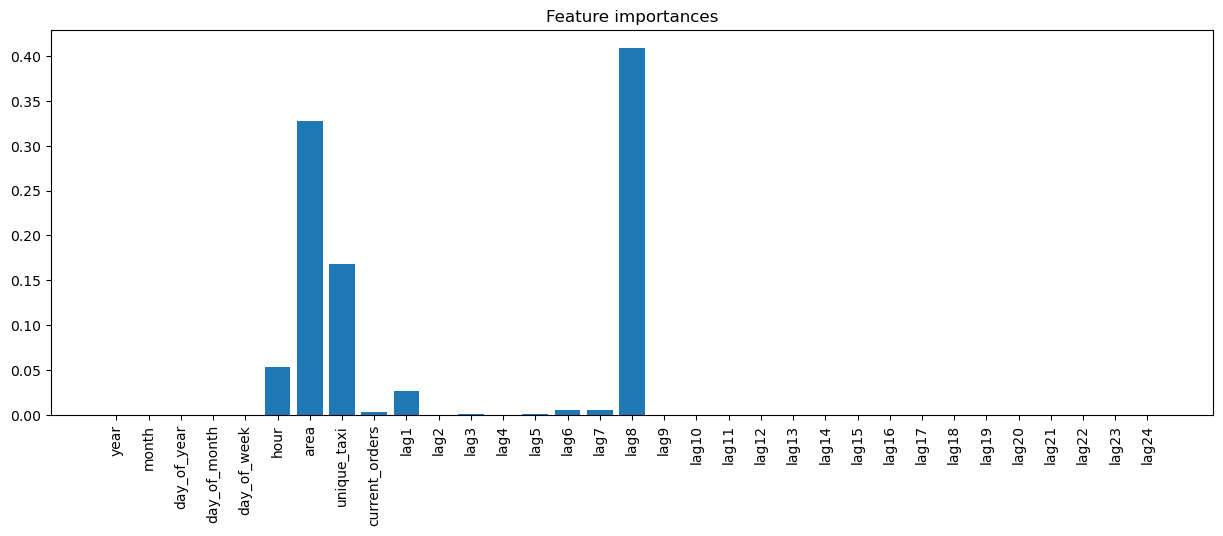

RMSE на кросс-валидации: 29.32766762387153


In [29]:
dtr = DecisionTreeRegressor(
    labelCol="target", 
    predictionCol='prediction', 
    seed=state
)

model_summary(dtr)
print(f'RMSE на кросс-валидации: {custom_cv(dtr)}')

#### RandomForestRegressor

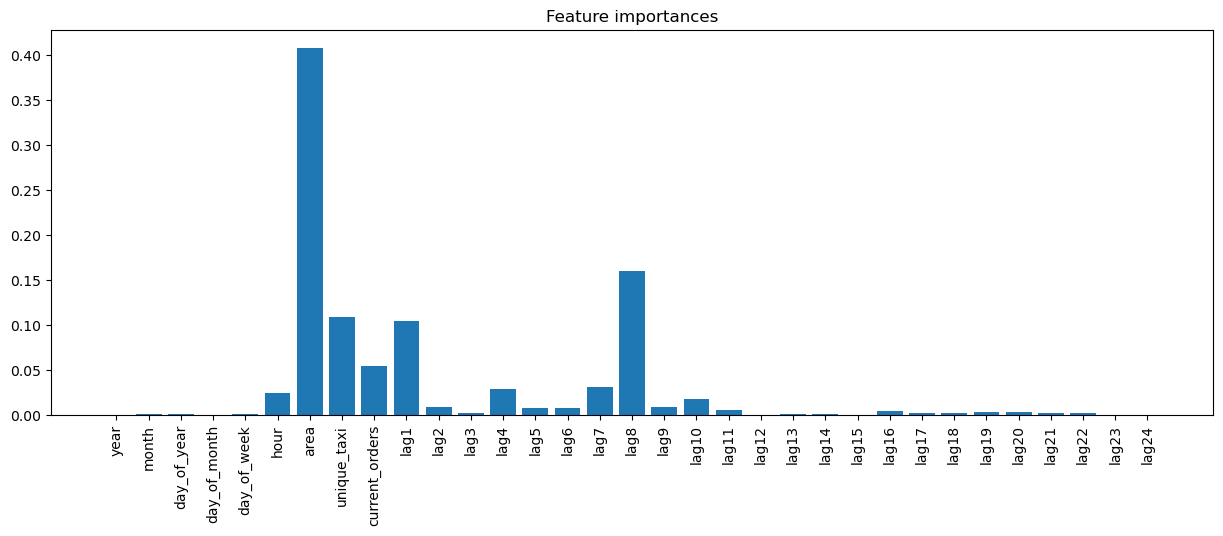

RMSE на кросс-валидации: 31.064248818883566


In [30]:
rfr = RandomForestRegressor(
    labelCol="target", 
    predictionCol='prediction', 
    seed=state
)

model_summary(rfr)
print(f'RMSE на кросс-валидации: {custom_cv(rfr)}')

#### GBTRegressor

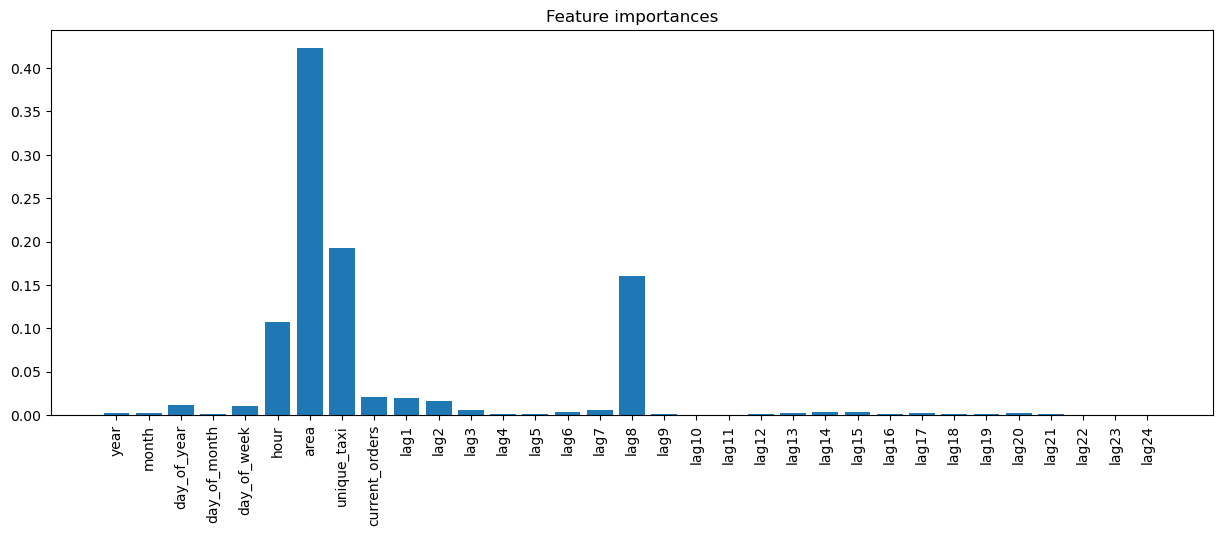

RMSE на кросс-валидации: 26.351092120588458


In [31]:
gbtr = GBTRegressor(
    labelCol="target", 
    predictionCol='prediction', 
    seed=state
)

model_summary(gbtr)
print(f'RMSE на кросс-валидации: {custom_cv(gbtr)}')

Алгоритм градиентного бустинга показал лучшие результаты.

### Подбор гиперпараметров GBTRegressor

Ограничим вектор признаков только теми признаками, значение которых для модели превышает порог в 0.01.

In [32]:
threshold = 0.01

estimator = GBTRegressor(
    labelCol="target", 
    predictionCol='prediction', 
    seed=state
)

model = custom_pipeline(estimator).fit(train)

importances = model.stages[2].featureImportances.toArray()
filtered_features = [featureCols[i] for i, importance in enumerate(importances) if importance > threshold]

Подберём для модели оптимальные значения гиперпараметров `maxDepths` и `maxIters`.

In [33]:
maxDepths = np.arange(5, 16, 5)
maxIters = np.arange(20, 31, 10)

best_rmse = float("inf")
best_params = None

gbtr = GBTRegressor(
    labelCol="target", 
    predictionCol='prediction', 
    seed=state
)

total = len(maxDepths) * len(maxIters)
no_iter = 0

for depth in maxDepths:
    for iter in maxIters:
        gbtr.setMaxDepth(depth).setMaxIter(iter)
        current_rmse = custom_cv(gbtr, train, filtered_features)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_params = (depth, iter)
        no_iter += 1
        print('Завершено', no_iter, 'из', total, 'итераций', end='\r')

print(f'Лучшее RMSE = {best_rmse} при maxDepth={best_params[0]} и maxIter={best_params[1]}')

Лучшее RMSE = 24.72843878088705 при maxDepth=10 и maxIter=20


### Проверка модели на тестовой выборке

In [34]:
model = GBTRegressor(
    labelCol='target', 
    predictionCol='prediction',
    maxDepth=best_params[0],
    maxIter=best_params[1],
    seed=state
)

test_metrics(model)

RMSE на test: 26.760979003818214, R2 на test: 0.7318641075488441


### Сравнение с Dummy Regressor

Напоследок сравним RMSE модели на тесте с RMSE дамми регрессора, заполненяющего предсказанные значения средним.

In [35]:
mean_value = train.select(avg('target')).collect()[0][0]
predictions = test.withColumn('prediction', lit(mean_value))

rmse = RegressionEvaluator(
    labelCol='target', 
    predictionCol='prediction', 
    metricName='rmse'
).evaluate(predictions)

r2 = RegressionEvaluator(
    labelCol='target', 
    predictionCol='prediction', 
    metricName='r2'
).evaluate(predictions)

print(f"Dummy Regressor RMSE = {rmse}, R2 = {r2}")

Dummy Regressor RMSE = 51.7436805730305, R2 = -0.0024566289217426984


Обученная модель справляется с предсказанием намного лучше, чем Dummy Regressor.

## Выводы

В ходе реализации проекта был проведён глубокий анализ доступных данных, применены несколько методов предобработки и выбраны наиболее подходящие алгоритмы машинного обучения. Построенная модель демонстрирует относительно высокую точность предсказаний, что позволило бы городским службам и бизнесу эффективнее реагировать на меняющиеся транспортные потоки. В процессе работы были выявлены основные факторы, влияющие на количество совершаемых поездок, что дает дополнительное понимание динамики движения в различных районах города.

Обученная модель GBTRegressor с гиперпараметрами `maxDepth=10` и `maxIter=20` на тестовой выборке показала результаты `RMSE = 26.76` и `R2 = 0.73`, что практически в два раза лучше результатов Dummy Regressora (`RMSE = 51.74` и `R2 = -0.002`), предсказывающих каждую сторку как среднее кол-во поездок. Высокий показатель `R2` (коэффициент детерминации) говорит о том, что 76% вариации зависимой переменной объясняется моделью, тогда как оставшиеся 24% объясняются другими факторами, не учтенными в модели. Такое значение `R2`76 считается довольно высоким и указывает на то, что модель довольно хорошо объясняет вариацию данн.ых

В заключение, проект дал важные инсайты в области городской мобильности и подтвердил ценность применения машинного обучения для решения актуальных городских проблем. В будущем возможно дальнейшее усовершенствование модели с учетом новых данных и трендов, применением новых алгоритмов обучения и группировки данных.

### Возможные области применения

1) <strong>Транспортное планирование</strong>: Основная потенциальная область применения данного проекта.С помощью предсказаний о количестве поездок можно оптимизировать распределение транспортных средств (например, автобусов или такси), чтобы удовлетворить спрос в пиковые часы. Городские службы могут использовать прогнозы для оптимизации движения, уменьшения пробок и повышения эффективности дорожной сети.
   
2)  <strong>Управление ресурсами такси и каршеринга</strong>: Компании, предоставляющие услуги такси или каршеринга, могут эффективно распределять свои автомобили в районах с наибольшим спросом.
   
3)  <strong>Безопасность</strong>: Распределение полиции или служб безопасности может быть оптимизировано на основе прогнозируемого потока людей в разных районах.
   
4)  <strong>Развитие инфраструктуры</strong>: Если в определенных районах ожидается увеличение количества поездок, это может служить сигналом к разработке новых транспортных маршрутов или улучшению инфраструктуры.
    
5)  <strong>Бизнес</strong>: Предприятия, такие как рестораны, магазины или кафе, могут использовать эти данные для принятия решений о том, где и когда открывать свои заведения или проводить рекламные акции.
    
6)  <strong>Экология</strong>: Прогнозирование потока транспортных средств поможет в планировании мероприятий по уменьшению загрязнения воздуха в определенных районах.
    